# Import und Funktionen

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [56]:
import sys
import requests
import tarfile
import json
import numpy as np
from os import path
from PIL import Image
from PIL import ImageFont, ImageDraw
from glob import glob
from matplotlib import pyplot as plt
import cv2

from tensorflow import keras

from keras.preprocessing.image import load_img, array_to_img, img_to_array

import random
from tqdm import tqdm

import re
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import CSVLogger
from sklearn.model_selection import train_test_split

In [32]:
def cust(x):
    return tf.keras.backend.sigmoid(x)-0.5

def createModel(InputDimension):
    
    input_img = tf.keras.layers.Input(shape=(420,540,1), name='image_input')
    
    #enoder 
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = tf.keras.layers.MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = tf.keras.layers.MaxPooling2D((2,2), padding='same', name='pool2')(x)
    
    #decoder
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = tf.keras.layers.UpSampling2D((2,2), name='upsample1')(x)
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = tf.keras.layers.UpSampling2D((2,2), name='upsample2')(x)
    x = tf.keras.layers.Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    #model
    autoencoder = tf.keras.Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

# Ausführung

## Daten Aufbau

In [44]:
x_Size = 540
y_Size = 420

In [4]:
xTrain = []
yTrain = []

In [ ]:
!mkdir train
!mkdir train_cleaned

!cp -v drive/My\ Drive/TestDataForNeuBau/train/* train
!cp drive/My\ Drive/TestDataForNeuBau/train_cleaned/* train_cleaned

In [59]:
path_X = "train/"
path_Y = "train_cleaned/"

train_images = sorted(os.listdir(path_X))
train_labels = sorted(os.listdir(path_Y))

X = []
Y = []

for img in train_images:
    img = load_img(path_X  + "/" + img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img in train_labels:
    img = load_img(path_Y + "/" + img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)


X = np.array(X)
Y = np.array(Y)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Size of X :  (144, 420, 540, 1)
Size of Y :  (144, 420, 540, 1)


In [60]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

Total number of training samples:  (129, 420, 540, 1)
Total number of validation samples:  (15, 420, 540, 1)


## Fit

In [86]:
InputDimension = (y_Size, x_Size, 3)

model = createModel(InputDimension)

print(model.summary())

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 420, 540, 1)]     0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 420, 540, 32)      320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 210, 270, 32)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 210, 270, 64)      18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 105, 135, 64)      0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 105, 135, 64)      36928     
_________________________________________________________________
upsample1 (UpSampling2D)     (None, 210, 270, 64)      0  

In [87]:
csv_logger = CSVLogger('log.csv', append=True, separator=';')

history = model.fit(X_train, y_train, epochs=1000, batch_size=1, validation_data=(X_valid, y_valid), callbacks=[csv_logger])

model.save('model')

Epoch 1/1000
129/129 [==============================] - 1s 11ms/step - loss: 0.2786 - val_loss: 0.2073
Epoch 2/1000
129/129 [==============================] - 1s 9ms/step - loss: 0.1708 - val_loss: 0.1649
Epoch 3/1000
129/129 [==============================] - 1s 9ms/step - loss: 0.1479 - val_loss: 0.1493
Epoch 4/1000
129/129 [==============================] - 1s 9ms/step - loss: 0.1359 - val_loss: 0.1405
Epoch 5/1000
129/129 [==============================] - 1s 9ms/step - loss: 0.1304 - val_loss: 0.1362
Epoch 6/1000
129/129 [==============================] - 1s 9ms/step - loss: 0.1261 - val_loss: 0.1323
Epoch 7/1000
129/129 [==============================] - 1s 9ms/step - loss: 0.1224 - val_loss: 0.1301
Epoch 8/1000
129/129 [==============================] - 1s 9ms/step - loss: 0.1194 - val_loss: 0.1262
Epoch 9/1000
129/129 [==============================] - 1s 9ms/step - loss: 0.1174 - val_loss: 0.1238
Epoch 10/1000
129/129 [==============================] - 1s 9ms/step - loss: 0.11

# Auswerung

In [88]:
plt.xkcd()

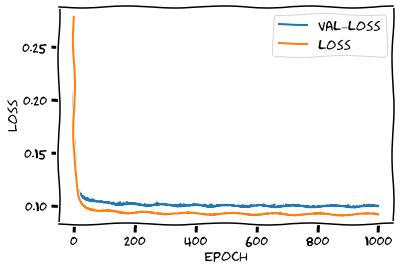

In [89]:
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

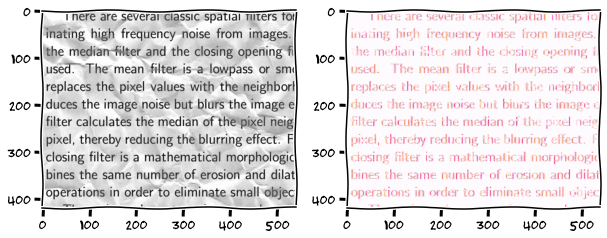

In [103]:
toPlot = model.predict(label[0])

predicted_label = np.squeeze(toPlot)

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(X_train[0]), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label), cmap='gray')
plt.show()